In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [20]:
df = pd.read_csv('./kospi_data.csv')
df.describe()

,Close,Open,High,Low,Volume,Change
count,11024.000000,11024.000000,11024.000000,11024.000000,1.102400e+04,11024.000000
mean,1121.077967,1121.552291,1127.448217,1114.365044,2.556932e+08,0.000379
std,772.891667,773.393378,777.129136,768.310046,2.938432e+08,0.014550
min,105.990000,105.990000,105.990000,105.990000,1.660000e+05,-0.120200
25%,586.562500,586.482500,589.730000,582.837500,1.208750e+07,-0.006300
50%,878.105000,878.015000,882.360000,873.430000,2.264900e+08,0.000300
75%,1891.347500,1892.090000,1902.320000,1880.635000,4.028000e+08,0.007200
max,3305.210000,3305.460000,3316.080000,3295.440000,3.460000e+09,0.119500


In [21]:
df = pd.read_csv('./kospi_data.csv')
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

label = []
for test in list(df['Change']):
    if test >= 0:
        label.append(1)
    else:
        label.append(0)
df['label'] = pd.DataFrame(label)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11024 entries, 0 to 11023
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11024 non-null  datetime64[ns]
 1   Close   11024 non-null  float64       
 2   Open    11024 non-null  float64       
 3   High    11024 non-null  float64       
 4   Low     11024 non-null  float64       
 5   Volume  11024 non-null  float64       
 6   Change  11024 non-null  float64       
 7   label   11024 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 689.1 KB
None


# 이동평균선

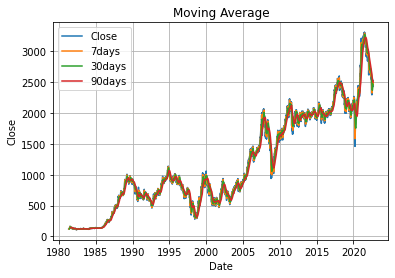

In [3]:
plt.plot(df['Date'],df['Close'].rolling(window=1).mean())
plt.plot(df['Date'],df['Close'].rolling(window=7).mean())
plt.plot(df['Date'],df['Close'].rolling(window=30).mean())
plt.plot(df['Date'],df['Close'].rolling(window=90).mean())

plt.grid()
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Moving Average')
plt.legend(['Close','7days','30days','90days'])

# Secondary y-axis

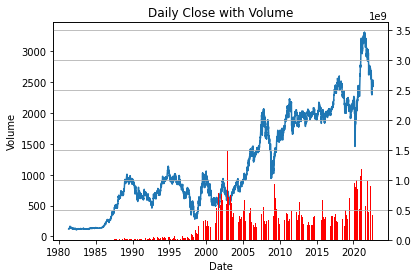

In [4]:
fig, ax1 = plt.subplots()
ax1.plot(df['Date'], df['Close'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Close')

ax2 = ax1.twinx()
ax1.set_ylabel('Volume')
ax2.bar(df['Date'], df['Volume'],color='red')

plt.title('Daily Close with Volume')
plt.grid()

# 월간 boxplot

<AxesSubplot:>

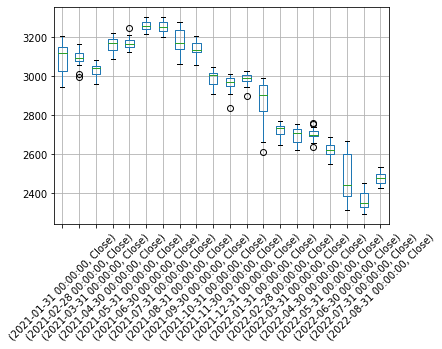

In [5]:
df[df['Date'] > '2021-01-01'].loc[:,['Date','Close']].groupby([pd.Grouper(key='Date', freq='1M')]).boxplot(subplots=False
                                                                                   ,sharex=True,rot=45)



# Classification

- Method bundle
- Grid search
- Feature selection (skip) : combination rule

In [6]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression # 앙상블 조합용
from sklearn.neighbors import KNeighborsClassifier # 앙상블 조합용
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
# from itertools import combinations
import warnings

warnings.filterwarnings('ignore')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,['Volume','Open','High','Low']],df.iloc[:,-1],train_size=0.2)
clf = DecisionTreeClassifier(random_state=10,
                                      max_depth=3,
                                      min_samples_leaf=3,
                                      min_samples_split=3)
clf.fit(X_train, y_train)  # classifier

acc_pred = clf.predict(X_test)
acc = np.round(accuracy_score(y_test, acc_pred), 4)

print(acc)

0.5161


In [8]:
class Prediction():
    def __init__(self): # input : classifier,features
        df = pd.read_csv('./kospi_data.csv')

        label = []
        for test in list(df['Change']):
            if test >= 0:
                label.append(1)
            else:
                label.append(0)
        df['label'] = pd.DataFrame(label)
        

        self.df = df.loc[:,['Volume','Open','High','Low']]
        self.label = pd.DataFrame(df.iloc[:-30,-1])
        self.pred_target = pd.DataFrame(df.loc[len(df)-30:,['Volume','Open','High','Low']])

    # bundle(dtc(),)
    def bundle(self, classifier, features, test_size):

        total_tbl_train = self.df.loc[:len(df)-31,['Volume','Open','High','Low']]
        total_tbl_label = self.label

        X_train, X_test, y_train, y_test = train_test_split(total_tbl_train
                                                            , total_tbl_label
                                                            , test_size=test_size,
                                                            random_state=10)

        #DecisionTree = DecisionTreeClassifier(random_state=10)
        #Logistic = LogisticRegression(random_state=10)
        #KNeighbors = KNeighborsClassifier(n_neighbors=4)
        #Voting = VotingClassifier(estimators=[('LR', Logistic), ('KN', KNeighbors)], voting='hard')
        #RandomForest = RandomForestClassifier(random_state=10)
        #GradientBoosting = GradientBoostingClassifier(random_state=10)
        #XGB = xgb.XGBClassifier(random_state=10)
        #choice = {'DecisionTree': self.dtc(), 'Logistic': Logistic, 'KNeighbors': KNeighbors,
        #          'Voting': Voting, 'RandomForest': RandomForest, 'GradientBoosting': GradientBoosting,
        #          'XGB': XGB}

        clf = classifier
        clf.fit(X_train, y_train)  # classifier
        acc_pred = clf.predict(X_test)
        acc = np.round(accuracy_score(y_test, acc_pred), 4)

        pred = clf.predict(np.array(self.pred_target[features])) # .reshape(1,-1)

        return round(acc * 100, 2),pred

    def dtc(self,max_depth,min_samples_leaf,min_samples_split):

        return DecisionTreeClassifier(random_state=10,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split)

    def logi(self,l1_ratio):
        return LogisticRegression(random_state=10,penalty='elasticnet',l1_ratio=l1_ratio,solver='saga')

    def kNN(self,n_neighbors):
        return KNeighborsClassifier(n_neighbors=n_neighbors)

    def Vote(self):
        return VotingClassifier(estimators=[('LR', self.logi(0.5)), ('KN', self.kNN(4))])

    def RanF(self,max_depth,min_samples_leaf,min_samples_split,max_samples):
        return RandomForestClassifier(random_state=10,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split,
                                      bootstrap=True,
                                      max_samples=max_samples)

    def GradB(self,max_depth,min_samples_leaf,min_samples_split,learning_rate):
        return GradientBoostingClassifier(random_state=10,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          min_samples_split=min_samples_split,
                                          learning_rate=learning_rate)

    def xgB(self):
        return xgb.XGBClassifier(random_state=10)


In [9]:
pr = Prediction()
pr.bundle(pr.xgB(),['Volume','Open','High','Low'],0.2)

(59.35,
 array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 1]))

In [13]:
class best(Prediction):
    def __init__(self):
        self.result = []
#         print('start')
#         self.result.append(self.dtc_best())
#         print('dtc fin')
#         self.result.append(self.logi_best())
#         print('logi fin')
#         self.result.append(self.knn_best())
#         print('knn fin')
#         self.result.append(self.vote_best())
#         print('vote fin')
#         self.result.append(self.ranf_best())
#         print('ranf fin')
#         self.result.append(self.grad_best())
#         print('grad fin')
#         self.result.append(self.xgb_best())
#         print('xgb fin')


    def dtc_best(self):
        prediction_method = Prediction()
        train_test_rate = 0.2

        features = ['Volume','Open','High','Low']
        tp = []
        idx = []
        for i in range(1,10):
            for j in range(1,10):
                for k in range(2,10):
                    for l in range(1,len(features)+1):
                        for feature in list(combinations(features,l)):
                            np.random.seed(10)
                            #print(np.random.rand(5))
                            tp.append(prediction_method.bundle(prediction_method.dtc(i,j,k), list(feature), train_test_rate)[0])
                            idx.append([i,j,k,feature])
                            #print([i,j,k,feature])
        return 'dtc',idx[tp.index(max(tp))],max(tp)

    def logi_best(self):
        prediction_method = Prediction()
        train_test_rate = 0.2

        features = ['Volume','Open','High','Low']
        tp = []
        idx = []
        for i in range(0,101,5):
            for l in range(1,len(features)+1):
                #for feature in list(combinations(features,l)):
                np.random.seed(10)
                #print(np.random.rand(5))
                tp.append(prediction_method.bundle(prediction_method.logi(i/100), features, train_test_rate)[0])
                idx.append([i,features])
                #print([i/100,feature])

        return 'logi',idx[tp.index(max(tp))],max(tp)

    def knn_best(self):
        prediction_method = Prediction()
        train_test_rate = 0.2

        features = ['Volume','Open','High','Low']
        tp = []
        idx = []
        for i in range(1,11):
            for l in range(1,len(features)+1):
                #for feature in list(combinations(features,l)):
                np.random.seed(10)
                #print(np.random.rand(5))
                tp.append(prediction_method.bundle(prediction_method.kNN(i), features, train_test_rate)[0])
                idx.append([i,features])
                #print([i,feature])

        return 'knn',idx[tp.index(max(tp))],max(tp)

    def vote_best(self):
        prediction_method = Prediction()
        train_test_rate = 0.2

        features = ['Volume','Open','High','Low']
        tp = []
        idx = []

        for l in range(1,len(features)+1):
            #for feature in list(combinations(features,l)):
            np.random.seed(10)
            #print(np.random.rand(5))
            tp.append(prediction_method.bundle(prediction_method.Vote(), features, train_test_rate)[0])
            idx.append([features])
            #print([feature])

        return 'vote',idx[tp.index(max(tp))],max(tp)

    def ranf_best(self):
        prediction_method = Prediction()
        train_test_rate = 0.2

        features = ['Volume','Open','High','Low']
        tp = []
        idx = []
        for i in range(1,10):
            for j in range(1,10):
                for k in range(2,10):
                    for ms in range(10,101,10):
                        #for l in range(1,len(features)+1):
                        #    for feature in list(combinations(features,l)):
                        np.random.seed(10)
                        #print(np.random.rand(5))
                        tp.append(prediction_method.bundle(prediction_method.RanF(i,j,k,ms), features, train_test_rate)[0])
                        idx.append([i,j,k,ms,features])
                        #print([i,j,k,ms,features])
            print(f'{i}/10')

        return 'ranf',idx[tp.index(max(tp))],max(tp)

    def grad_best(self):
        prediction_method = Prediction()
        train_test_rate = 0.2

        features = ['Volume','Open','High','Low']
        tp = []
        idx = []
        for i in range(1,10):
            for j in range(1,10):
                for k in range(2,10):
                    for ms in range(1,5):
                        #for l in range(1,len(features)+1):
                        #    for feature in list(combinations(features,l)):
                        np.random.seed(10)
                        #print(np.random.rand(5))
                        tp.append(prediction_method.bundle(prediction_method.GradB(i,j,k,ms/10), features, train_test_rate)[0])
                        idx.append([i,j,k,ms/10,features])
                        #print([i,j,k,ms/10,features])
            print(f'{i}/10')

        return 'grad',idx[tp.index(max(tp))],max(tp)

    def xgb_best(self):
        prediction_method = Prediction()
        train_test_rate = 0.2

        features = ['Volume','Open','High','Low']
        tp = []
        idx = []

        for l in range(1,len(features)+1):
            #for feature in list(combinations(features,l)):
            np.random.seed(10)
            #print(np.random.rand(5))
            tp.append(prediction_method.bundle(prediction_method.xgB(), features, train_test_rate)[0])
            idx.append([features])
            #print([feature])

        return 'xgb',idx[tp.index(max(tp))],max(tp)

In [11]:
bst = best()

start
dtc fin
logi fin
knn fin
vote fin
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
ranf fin
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
grad fin
xgb fin


In [12]:
bst.xgb_best()

('xgb', [['Volume', 'Open', 'High', 'Low']], 59.35)

In [18]:
summary = pd.DataFrame(bst.result)
summary.columns = ['Method','Parms','Acc']
summary

,Method,Parms,Acc
0,dtc,"[6, 1, 2, [Volume, Open, High, Low]]",54.48
1,logi,"[0, [Volume, Open, High, Low]]",52.25
2,knn,"[9, [Volume, Open, High, Low]]",52.02
3,vote,"[[Volume, Open, High, Low]]",49.39
4,ranf,"[5, 1, 8, 100, [Volume, Open, High, Low]]",55.93
5,grad,"[7, 9, 2, 0.2, [Volume, Open, High, Low]]",62.71
6,xgb,"[[Volume, Open, High, Low]]",59.35


- example

- dtc : 

        DecisionTreeClassifier(random_state=10,
                      max_depth=max_depth,
                      min_samples_leaf=min_samples_leaf,
                      min_samples_split=min_samples_split)

# Spline smoothing graph